In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
np.random.seed(91828)


In [3]:
def class_to_int(label , cl):
    temp = []
    for i in range(len(label)):
        #print(label[i])
        for j in range(len(cl)):
            if(label[i]==cl[j]):
                temp.append(j) 
    return temp
classes = ['BH' ,'NS' ]
ns_n = 0 
bh_n = 0


In [4]:

def get_xy(data):
    y = data['class']
    s = data['significance']
    info = data[['src_n' , 'src_id']]
    x = data.drop(columns=[ 'class' ,'src_n' ,'src_id' , 'significance'])
    #display(x)
    y_train_int = class_to_int(y, classes)
    one_hot_y_train =  to_categorical(y_train_int)
    global ns_n 
    global bh_n
    ns_n = float(y.value_counts()['NS']) 
    bh_n =  float(y.value_counts()['BH'])    
    print(ns_n , bh_n)
    return x , one_hot_y_train

In [5]:
def fit_model(model , x_train , one_hot_y_train , verbose=0 , validation=0.2):
    global ns_n 
    global bh_n 
    class_weight = {0: (ns_n/bh_n),
                    1: 1}
    history = model.fit(x_train, one_hot_y_train, batch_size=64, epochs=120, validation_split=validation, class_weight=class_weight, verbose=verbose )
    return history

In [6]:
def res_score(model , x , y ):
    y_prob = model.predict(x)
    y_pred = np.zeros_like(y_prob)
    y_pred[np.arange(len(y_prob)), y_prob.argmax(1)] = 1
    cf = np.matrix(np.matmul(y.T , y_pred))
    total = cf.sum()
    row_sum = cf.sum(axis=0)
    acc = np.trace(cf) / total 
    col_sum = cf.sum(axis=1) 
    #print(cf)
    return cf , acc


#_ , score = res_score(model , x , one_hot_y_train)
#print(score)

In [13]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
def mc_validation(model_func = '' , x = '' , split_data = '' , s=0.8 , model_name = '' , d_type = '' , impute_method = ''):
    from sklearn.model_selection import KFold
    kfold = KFold(8, True, 1)
    #k-fold cross-validation
    train_acc = []
    test_acc = []
    index = np.arange(0,len(x))
    split_no = int(len(x)*s)
    print('split_no' , split_no)
    np.random.shuffle(index)
    data = x.copy()
    data = data.sample(frac=1)
    x =  data.drop(columns=['class' , 'src_n' ,'src_id' ,'significance'])
    y = data['class']
    for i in tqdm(range(32)):
        x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , stratify=y)
        x_train.insert(0 , 'class' , y_train)
        x_test.insert(0 , 'class' , y_test)
        #x_train , x_test = split_data(data)
        tf_data_train = tfdf.keras.pd_dataframe_to_tf_dataset(x_train,label="class")
        tf_data_test = tfdf.keras.pd_dataframe_to_tf_dataset(x_test,label="class")
        model = model_func()
        with sys_pipes():
            model.fit(tf_data_train)
        model.compile(metrics=['accuracy'])

        evaluation = model.evaluate(tf_data_train, return_dict=True)
        _ ,  train_acc_temp = evaluation.items()
        train_acc_temp = train_acc_temp[1]
        evaluation = model.evaluate(tf_data_test, return_dict=True)
        _ ,  test_acc_temp = evaluation.items()
        test_acc_temp = test_acc_temp[1]
        #_,train_acc_temp = res_score(model , xtr , ytr)
        #_,test_acc_temp = res_score(model , xtst , ytst)
        train_acc.append(train_acc_temp)
        test_acc.append(test_acc_temp)
        #print('-----------------------------------')
        #print('training_acc :' , train_acc_temp)
        #print('test_acc :' , test_acc_temp)
    acc_train =  pd.DataFrame()
    acc_test = pd.DataFrame()

    
    acc_test.insert(0 , 'acc_type' , ['Test_acc']*len(train_acc))
    acc_test.insert(1 , 'accuracy' , test_acc)
    acc_test = acc_test.reset_index(drop=True)
   
    acc_train.insert(0 , 'acc_type' , ['Train_acc']*len(train_acc))
    acc_train.insert(1 , 'accuracy' , train_acc)
    acc_train = acc_train.reset_index(drop=True)

    acc = pd.concat([acc_train , acc_test]).reset_index(drop=True)
    acc.insert(0 , 'model' , [model_name]*len(acc))
    acc.insert(1 , 'data_processing' , [d_type]*len(acc))
    acc.insert(1 , 'impute_method' , [impute_method]*len(acc))
    return acc


In [8]:
def src_split(data_sent , s = (5 , 8) ):
    data = data_sent.copy().reset_index(drop=True)
    data_bh =  data[data['class']=='BH'].sample(frac=1)
    data_ns =  data[data['class']=='NS'].sample(frac=1)
    n_bh  , n_ns = s 
    
    src_bh =  np.unique(data_bh['src_id'])
    np.random.shuffle(src_bh)
    src_ns = np.unique(data_ns['src_id'])
    np.random.shuffle(src_ns)
    s_bh = len(src_bh) - n_bh 
    s_ns = len(src_ns) - n_ns 
    print(s_bh , s_ns)
    src_bh_train = src_bh[:s_bh]
    src_bh_test = src_bh[s_bh:]
    src_ns_train = src_ns[:s_ns]
    src_ns_test = src_ns[s_ns:]
    print(src_bh_test)
    train_bh = data_bh[data_bh['src_id'].isin(src_bh_train)].reset_index(drop=True)
    test_bh = data_bh[data_bh['src_id'].isin(src_bh_test)].reset_index(drop=True)

    train_ns = data_ns[data_ns['src_id'].isin(src_ns_train)].reset_index(drop=True)
    test_ns = data_ns[data_ns['src_id'].isin(src_ns_test)].reset_index(drop=True)

    train = pd.concat([train_bh , train_ns]).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)

    test = pd.concat([test_bh , test_ns]).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)
    return train , test 

def obs_split(data_sent , s = 0.8):
    data = data_sent.copy()
    data = data.sample(frac=1)
    split_no = int(len(data)*s)
    train = data[:split_no]
    test = data[split_no:]
    return train, test

In [10]:
data_norm = pd.read_csv('processed_data/train_norm' , index_col=0).reset_index(drop=True)
data_std = pd.read_csv('processed_data/train_std' , index_col=0).reset_index(drop=True)
data_og = pd.read_csv('processed_data/train_og' , index_col=0).reset_index(drop=True)
data_norm.head(2)

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
0,NS,XMMU J004245.2+41172,NS0044,49.26,0.440071,0.357367,0.418632,0.398875,0.439279,0.510417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NS,GRS 1741.9-2853,NS0021,376.06,0.344546,0.000000,0.305586,0.534511,0.477879,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data_nan = pd.read_csv('processed_data/train_norm_no' , index_col=0).reset_index(drop=True)

# Keras Random Forest Classifier

In [11]:
import tensorflow_decision_forests as tfdf
from wurlitzer import sys_pipes
gen_model_rf =  tfdf.keras.RandomForestModel

In [14]:
acc_norm_nan_rf = mc_validation(gen_model_rf , data_nan, obs_split ,model_name = 'RF' , d_type='Normalized' , impute_method='No_impute')

/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


split_no 368


  0%|          | 0/32 [00:00<?, ?it/s]

6/6 [==============================] - 1s 8ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:320 (86.9565%) mean:0.097847 min:0 max:0.451509 sd:0.132329
	1: "bb_ampl_hilim" NUMERICAL num-nas:320 (86.9565%) mean:0.118775 min:0 max:0.603673 sd:0.161189
	2: "bb_ampl_lolim" NUMERICAL num-nas:320 (86.9565%) mean:0.0781388 min:0 max:0.388463 sd:0.110101
	3: "bb_kt" NUMERICAL num-nas:320 (86.9565%) mean:0.176675 min:0.00335387 max:1 sd:0.207
	4: "bb_kt_hilim" NUMERICAL num-nas:320 (86.9565%) mean:0.026462 min:0.000195345 max:1 sd:0.14219
	5: "bb_kt_lolim" NUMERICAL num-nas:320 (86.9565%) mean:0.156263 min:0.000481116 max:1 sd:0.173259
	6: "bb_nh" NUMERICAL num-nas:320 (86.9565%) me

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8804


  3%|▎         | 1/32 [00:05<03:00,  5.82s/it]

6/6 [==============================] - 1s 9ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:325 (88.3152%) mean:0.102743 min:7.20293e-05 max:1 sd:0.187407
	1: "bb_ampl_hilim" NUMERICAL num-nas:325 (88.3152%) mean:0.113087 min:7.14336e-05 max:1 sd:0.19683
	2: "bb_ampl_lolim" NUMERICAL num-nas:325 (88.3152%) mean:0.0903425 min:3.5212e-05 max:1 sd:0.178484
	3: "bb_kt" NUMERICAL num-nas:325 (88.3152%) mean:0.164191 min:0 max:0.660713 sd:0.129323
	4: "bb_kt_hilim" NUMERICAL num-nas:325 (88.3152%) mean:0.00568078 min:0 max:0.02396 sd:0.00471527
	5: "bb_kt_lolim" NUMERICAL num-nas:325 (88.3152%) mean:0.151554 min:0 max:0.586641 sd:0.115893
	6: "bb_nh" NUMERICAL num-nas:325 (88.315

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8804


  6%|▋         | 2/32 [00:09<02:23,  4.80s/it]

6/6 [==============================] - 1s 6ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:323 (87.7717%) mean:0.0994784 min:0 max:1 sd:0.180675
	1: "bb_ampl_hilim" NUMERICAL num-nas:323 (87.7717%) mean:0.112206 min:0 max:1 sd:0.189858
	2: "bb_ampl_lolim" NUMERICAL num-nas:323 (87.7717%) mean:0.0866123 min:0 max:1 sd:0.173349
	3: "bb_kt" NUMERICAL num-nas:323 (87.7717%) mean:0.174813 min:0 max:1 sd:0.209552
	4: "bb_kt_hilim" NUMERICAL num-nas:323 (87.7717%) mean:0.0277987 min:0 max:1 sd:0.146752
	5: "bb_kt_lolim" NUMERICAL num-nas:323 (87.7717%) mean:0.153278 min:0 max:1 sd:0.173369
	6: "bb_nh" NUMERICAL num-nas:323 (87.7717%) mean:0.059508 min:0 max:0.496254 sd:0.138493
	

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8696


  9%|▉         | 3/32 [00:13<02:01,  4.20s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:326 (88.587%) mean:0.0752038 min:0 max:0.395994 sd:0.117487
	1: "bb_ampl_hilim" NUMERICAL num-nas:326 (88.587%) mean:0.0949059 min:0 max:0.603673 sd:0.152208
	2: "bb_ampl_lolim" NUMERICAL num-nas:326 (88.587%) mean:0.0579546 min:0 max:0.388463 sd:0.0926445
	3: "bb_kt" NUMERICAL num-nas:326 (88.587%) mean:0.189083 min:0.00335387 max:1 sd:0.212112
	4: "bb_kt_hilim" NUMERICAL num-nas:326 (88.587%) mean:0.0298567 min:0.000195345 max:1 sd:0.151698
	5: "bb_kt_lolim" NUMERICAL num-nas:326 (88.587%) mean:0.165542 min:0.000481116 max:1 sd:0.17521
	6: "bb_nh" NUMERICAL num-nas:326 (88.587%) me

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 12%|█▎        | 4/32 [00:16<01:46,  3.80s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:322 (87.5%) mean:0.0964404 min:0 max:0.451509 sd:0.134164
	1: "bb_ampl_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.117194 min:0 max:0.603673 sd:0.163578
	2: "bb_ampl_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.0771096 min:0 max:0.388463 sd:0.111713
	3: "bb_kt" NUMERICAL num-nas:322 (87.5%) mean:0.166522 min:0.00335387 max:0.946182 sd:0.173325
	4: "bb_kt_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.0267888 min:0.000195345 max:1 sd:0.145152
	5: "bb_kt_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.14431 min:0.000481116 max:0.586641 sd:0.124817
	6: "bb_nh" NUMERICAL num-nas:322 (87.5%) mean

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 16%|█▌        | 5/32 [00:19<01:37,  3.60s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:322 (87.5%) mean:0.10005 min:0 max:1 sd:0.182687
	1: "bb_ampl_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.116211 min:0 max:1 sd:0.201537
	2: "bb_ampl_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.0837546 min:0 max:1 sd:0.168955
	3: "bb_kt" NUMERICAL num-nas:322 (87.5%) mean:0.188946 min:0 max:1 sd:0.209901
	4: "bb_kt_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.0277985 min:0 max:1 sd:0.145118
	5: "bb_kt_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.166463 min:0 max:1 sd:0.174552
	6: "bb_nh" NUMERICAL num-nas:322 (87.5%) mean:0.0635543 min:0 max:1 sd:0.172903
	7: "bb_nh_hilim" NUMERICAL nu

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 19%|█▉        | 6/32 [00:22<01:27,  3.38s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:322 (87.5%) mean:0.102173 min:0 max:1 sd:0.186331
	1: "bb_ampl_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.116023 min:0 max:1 sd:0.202664
	2: "bb_ampl_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.0879506 min:0 max:1 sd:0.17465
	3: "bb_kt" NUMERICAL num-nas:322 (87.5%) mean:0.185279 min:0 max:1 sd:0.207918
	4: "bb_kt_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.0276073 min:0 max:1 sd:0.145139
	5: "bb_kt_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.164524 min:0 max:1 sd:0.17349
	6: "bb_nh" NUMERICAL num-nas:322 (87.5%) mean:0.0678251 min:0 max:1 sd:0.180173
	7: "bb_nh_hilim" NUMERICAL num

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8696


 22%|██▏       | 7/32 [00:25<01:21,  3.25s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:321 (87.2283%) mean:0.099787 min:0 max:1 sd:0.177981
	1: "bb_ampl_hilim" NUMERICAL num-nas:321 (87.2283%) mean:0.117248 min:0 max:1 sd:0.196032
	2: "bb_ampl_lolim" NUMERICAL num-nas:321 (87.2283%) mean:0.0841963 min:0 max:1 sd:0.167935
	3: "bb_kt" NUMERICAL num-nas:321 (87.2283%) mean:0.184305 min:0 max:1 sd:0.209967
	4: "bb_kt_hilim" NUMERICAL num-nas:321 (87.2283%) mean:0.0272476 min:0 max:1 sd:0.143617
	5: "bb_kt_lolim" NUMERICAL num-nas:321 (87.2283%) mean:0.16102 min:0 max:1 sd:0.174925
	6: "bb_nh" NUMERICAL num-nas:321 (87.2283%) mean:0.0626524 min:0 max:0.496254 sd:0.134972
	7

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 25%|██▌       | 8/32 [00:28<01:15,  3.15s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:319 (86.6848%) mean:0.0941191 min:0 max:0.451509 sd:0.132064
	1: "bb_ampl_hilim" NUMERICAL num-nas:319 (86.6848%) mean:0.113561 min:0 max:0.603673 sd:0.160527
	2: "bb_ampl_lolim" NUMERICAL num-nas:319 (86.6848%) mean:0.0754518 min:0 max:0.388463 sd:0.109909
	3: "bb_kt" NUMERICAL num-nas:319 (86.6848%) mean:0.175263 min:0.00335387 max:1 sd:0.205507
	4: "bb_kt_hilim" NUMERICAL num-nas:319 (86.6848%) mean:0.0260618 min:0.000195345 max:1 sd:0.140763
	5: "bb_kt_lolim" NUMERICAL num-nas:319 (86.6848%) mean:0.153725 min:0.000481116 max:1 sd:0.170826
	6: "bb_nh" NUMERICAL num-nas:319 (86.684

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 28%|██▊       | 9/32 [00:31<01:11,  3.10s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:324 (88.0435%) mean:0.101765 min:7.20293e-05 max:1 sd:0.185213
	1: "bb_ampl_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.119088 min:7.14336e-05 max:1 sd:0.204321
	2: "bb_ampl_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.0855211 min:2.30324e-07 max:1 sd:0.172743
	3: "bb_kt" NUMERICAL num-nas:324 (88.0435%) mean:0.16252 min:0 max:1 sd:0.164906
	4: "bb_kt_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.00591479 min:0 max:0.0453877 sd:0.00711427
	5: "bb_kt_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.149923 min:0 max:1 sd:0.160102
	6: "bb_nh" NUMERICAL num-nas:324 (88.0435%) mean:0.

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 31%|███▏      | 10/32 [00:34<01:04,  2.95s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:326 (88.587%) mean:0.0661012 min:0 max:0.395994 sd:0.109093
	1: "bb_ampl_hilim" NUMERICAL num-nas:326 (88.587%) mean:0.0856858 min:0 max:0.603673 sd:0.14681
	2: "bb_ampl_lolim" NUMERICAL num-nas:326 (88.587%) mean:0.0490265 min:0 max:0.273173 sd:0.0798385
	3: "bb_kt" NUMERICAL num-nas:326 (88.587%) mean:0.197774 min:0.00335387 max:1 sd:0.216166
	4: "bb_kt_hilim" NUMERICAL num-nas:326 (88.587%) mean:0.0302085 min:0.000195345 max:1 sd:0.15165
	5: "bb_kt_lolim" NUMERICAL num-nas:326 (88.587%) mean:0.172115 min:0.000481116 max:1 sd:0.17962
	6: "bb_nh" NUMERICAL num-nas:326 (88.587%) mean

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 34%|███▍      | 11/32 [00:37<01:03,  3.02s/it]

6/6 [==============================] - 1s 6ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:324 (88.0435%) mean:0.110842 min:0 max:1 sd:0.187807
	1: "bb_ampl_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.131242 min:0 max:1 sd:0.209116
	2: "bb_ampl_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.0917617 min:0 max:1 sd:0.173755
	3: "bb_kt" NUMERICAL num-nas:324 (88.0435%) mean:0.180083 min:0 max:1 sd:0.215957
	4: "bb_kt_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.0284906 min:0 max:1 sd:0.14835
	5: "bb_kt_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.157623 min:0 max:1 sd:0.17978
	6: "bb_nh" NUMERICAL num-nas:324 (88.0435%) mean:0.0530528 min:0 max:0.478136 sd:0.122678
	7:

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9457


 38%|███▊      | 12/32 [00:40<01:01,  3.09s/it]

6/6 [==============================] - 1s 7ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:318 (86.413%) mean:0.0848228 min:0 max:0.451509 sd:0.127705
	1: "bb_ampl_hilim" NUMERICAL num-nas:318 (86.413%) mean:0.104995 min:0 max:0.603673 sd:0.158603
	2: "bb_ampl_lolim" NUMERICAL num-nas:318 (86.413%) mean:0.0662153 min:0 max:0.388463 sd:0.102788
	3: "bb_kt" NUMERICAL num-nas:318 (86.413%) mean:0.167382 min:0.00335387 max:1 sd:0.191074
	4: "bb_kt_hilim" NUMERICAL num-nas:318 (86.413%) mean:0.0253607 min:0.000195345 max:1 sd:0.139395
	5: "bb_kt_lolim" NUMERICAL num-nas:318 (86.413%) mean:0.147078 min:0.000481116 max:1 sd:0.157657
	6: "bb_nh" NUMERICAL num-nas:318 (86.413%) mea

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 41%|████      | 13/32 [00:44<01:00,  3.19s/it]

6/6 [==============================] - 1s 7ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:324 (88.0435%) mean:0.110776 min:0 max:1 sd:0.189521
	1: "bb_ampl_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.129396 min:0 max:1 sd:0.209107
	2: "bb_ampl_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.0934369 min:0 max:1 sd:0.177206
	3: "bb_kt" NUMERICAL num-nas:324 (88.0435%) mean:0.18561 min:0 max:1 sd:0.215909
	4: "bb_kt_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.0286609 min:0 max:1 sd:0.148324
	5: "bb_kt_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.16316 min:0 max:1 sd:0.180158
	6: "bb_nh" NUMERICAL num-nas:324 (88.0435%) mean:0.075237 min:0 max:1 sd:0.186994
	7: "bb_nh_

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 44%|████▍     | 14/32 [00:47<00:58,  3.26s/it]

6/6 [==============================] - 1s 6ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:322 (87.5%) mean:0.114999 min:0 max:1 sd:0.186919
	1: "bb_ampl_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.133879 min:0 max:1 sd:0.206427
	2: "bb_ampl_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.0969426 min:0 max:1 sd:0.174226
	3: "bb_kt" NUMERICAL num-nas:322 (87.5%) mean:0.170783 min:0 max:1 sd:0.209865
	4: "bb_kt_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.0271409 min:0 max:1 sd:0.145211
	5: "bb_kt_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.150614 min:0 max:1 sd:0.174938
	6: "bb_nh" NUMERICAL num-nas:322 (87.5%) mean:0.046532 min:0 max:0.478136 sd:0.113106
	7: "bb_nh_hilim" NUMER

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 47%|████▋     | 15/32 [00:50<00:55,  3.29s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:323 (87.7717%) mean:0.0947491 min:0 max:0.451509 sd:0.130349
	1: "bb_ampl_hilim" NUMERICAL num-nas:323 (87.7717%) mean:0.11459 min:0 max:0.603673 sd:0.157732
	2: "bb_ampl_lolim" NUMERICAL num-nas:323 (87.7717%) mean:0.0762208 min:0 max:0.388463 sd:0.109798
	3: "bb_kt" NUMERICAL num-nas:323 (87.7717%) mean:0.153478 min:0.00335387 max:0.946182 sd:0.169059
	4: "bb_kt_hilim" NUMERICAL num-nas:323 (87.7717%) mean:0.0268543 min:0.000195345 max:1 sd:0.146773
	5: "bb_kt_lolim" NUMERICAL num-nas:323 (87.7717%) mean:0.130903 min:0.000481116 max:0.586641 sd:0.11724
	6: "bb_nh" NUMERICAL num-nas

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 50%|█████     | 16/32 [00:55<00:57,  3.60s/it]

6/6 [==============================] - 1s 6ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:324 (88.0435%) mean:0.0998901 min:0 max:1 sd:0.177653
	1: "bb_ampl_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.115969 min:0 max:1 sd:0.189744
	2: "bb_ampl_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.0850256 min:0 max:1 sd:0.170065
	3: "bb_kt" NUMERICAL num-nas:324 (88.0435%) mean:0.183887 min:0 max:1 sd:0.215649
	4: "bb_kt_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.0286344 min:0 max:1 sd:0.148328
	5: "bb_kt_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.160838 min:0 max:1 sd:0.179484
	6: "bb_nh" NUMERICAL num-nas:324 (88.0435%) mean:0.0664666 min:1.03904e-10 max:0.496254 sd

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8587


 53%|█████▎    | 17/32 [00:58<00:53,  3.58s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:322 (87.5%) mean:0.108734 min:0 max:1 sd:0.185141
	1: "bb_ampl_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.128699 min:0 max:1 sd:0.205874
	2: "bb_ampl_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.0899784 min:0 max:1 sd:0.171129
	3: "bb_kt" NUMERICAL num-nas:322 (87.5%) mean:0.186603 min:0 max:1 sd:0.211791
	4: "bb_kt_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.0277483 min:0 max:1 sd:0.145128
	5: "bb_kt_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.1636 min:0 max:1 sd:0.176723
	6: "bb_nh" NUMERICAL num-nas:322 (87.5%) mean:0.0755248 min:0 max:1 sd:0.182545
	7: "bb_nh_hilim" NUMERICAL num

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 56%|█████▋    | 18/32 [01:01<00:46,  3.33s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:324 (88.0435%) mean:0.0904122 min:7.20293e-05 max:1 sd:0.173327
	1: "bb_ampl_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.104158 min:7.14336e-05 max:1 sd:0.182939
	2: "bb_ampl_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.0766393 min:2.30324e-07 max:1 sd:0.165585
	3: "bb_kt" NUMERICAL num-nas:324 (88.0435%) mean:0.167542 min:0 max:1 sd:0.17955
	4: "bb_kt_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.00608638 min:0 max:0.0453877 sd:0.00756266
	5: "bb_kt_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.155175 min:0 max:1 sd:0.172269
	6: "bb_nh" NUMERICAL num-nas:324 (88.0435%) mean:0

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 59%|█████▉    | 19/32 [01:04<00:41,  3.18s/it]

6/6 [==============================] - 1s 6ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:326 (88.587%) mean:0.120582 min:7.20293e-05 max:1 sd:0.193928
	1: "bb_ampl_hilim" NUMERICAL num-nas:326 (88.587%) mean:0.138164 min:7.14336e-05 max:1 sd:0.211573
	2: "bb_ampl_lolim" NUMERICAL num-nas:326 (88.587%) mean:0.102562 min:2.30324e-07 max:1 sd:0.181395
	3: "bb_kt" NUMERICAL num-nas:326 (88.587%) mean:0.162527 min:0 max:1 sd:0.179682
	4: "bb_kt_hilim" NUMERICAL num-nas:326 (88.587%) mean:0.00589183 min:0 max:0.0453877 sd:0.00763527
	5: "bb_kt_lolim" NUMERICAL num-nas:326 (88.587%) mean:0.151611 min:0 max:1 sd:0.172575
	6: "bb_nh" NUMERICAL num-nas:326 (88.587%) mean:0.0770298

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 62%|██████▎   | 20/32 [01:08<00:41,  3.44s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:320 (86.9565%) mean:0.104539 min:0 max:1 sd:0.180533
	1: "bb_ampl_hilim" NUMERICAL num-nas:320 (86.9565%) mean:0.12 min:0 max:1 sd:0.193299
	2: "bb_ampl_lolim" NUMERICAL num-nas:320 (86.9565%) mean:0.0892127 min:0 max:1 sd:0.170628
	3: "bb_kt" NUMERICAL num-nas:320 (86.9565%) mean:0.169259 min:0 max:1 sd:0.195555
	4: "bb_kt_hilim" NUMERICAL num-nas:320 (86.9565%) mean:0.0261969 min:0 max:1 sd:0.142208
	5: "bb_kt_lolim" NUMERICAL num-nas:320 (86.9565%) mean:0.149855 min:0 max:1 sd:0.161616
	6: "bb_nh" NUMERICAL num-nas:320 (86.9565%) mean:0.0617676 min:0 max:1 sd:0.170853
	7: "bb_nh_h

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8696


 66%|██████▌   | 21/32 [01:12<00:38,  3.54s/it]

6/6 [==============================] - 1s 7ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:318 (86.413%) mean:0.0989615 min:0 max:1 sd:0.177794
	1: "bb_ampl_hilim" NUMERICAL num-nas:318 (86.413%) mean:0.118972 min:0 max:1 sd:0.199269
	2: "bb_ampl_lolim" NUMERICAL num-nas:318 (86.413%) mean:0.0809309 min:0 max:1 sd:0.163593
	3: "bb_kt" NUMERICAL num-nas:318 (86.413%) mean:0.176231 min:0 max:1 sd:0.205742
	4: "bb_kt_hilim" NUMERICAL num-nas:318 (86.413%) mean:0.0256598 min:0 max:1 sd:0.13938
	5: "bb_kt_lolim" NUMERICAL num-nas:318 (86.413%) mean:0.155488 min:0 max:1 sd:0.172114
	6: "bb_nh" NUMERICAL num-nas:318 (86.413%) mean:0.068291 min:0 max:1 sd:0.17721
	7: "bb_nh_hilim"

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9130


 69%|██████▉   | 22/32 [01:15<00:34,  3.48s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:326 (88.587%) mean:0.0749618 min:0 max:0.395994 sd:0.117204
	1: "bb_ampl_hilim" NUMERICAL num-nas:326 (88.587%) mean:0.0906347 min:0 max:0.603673 sd:0.143474
	2: "bb_ampl_lolim" NUMERICAL num-nas:326 (88.587%) mean:0.0611231 min:0 max:0.388463 sd:0.100864
	3: "bb_kt" NUMERICAL num-nas:326 (88.587%) mean:0.19487 min:0.00335387 max:1 sd:0.217282
	4: "bb_kt_hilim" NUMERICAL num-nas:326 (88.587%) mean:0.0301156 min:0.000195345 max:1 sd:0.151667
	5: "bb_kt_lolim" NUMERICAL num-nas:326 (88.587%) mean:0.169119 min:0.000481116 max:1 sd:0.180535
	6: "bb_nh" NUMERICAL num-nas:326 (88.587%) mea

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 72%|███████▏  | 23/32 [01:18<00:30,  3.40s/it]

6/6 [==============================] - 1s 6ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:320 (86.9565%) mean:0.115301 min:0 max:1 sd:0.184569
	1: "bb_ampl_hilim" NUMERICAL num-nas:320 (86.9565%) mean:0.135188 min:0 max:1 sd:0.204482
	2: "bb_ampl_lolim" NUMERICAL num-nas:320 (86.9565%) mean:0.0965076 min:0 max:1 sd:0.171516
	3: "bb_kt" NUMERICAL num-nas:320 (86.9565%) mean:0.173929 min:0 max:1 sd:0.202335
	4: "bb_kt_hilim" NUMERICAL num-nas:320 (86.9565%) mean:0.0263636 min:0 max:1 sd:0.142196
	5: "bb_kt_lolim" NUMERICAL num-nas:320 (86.9565%) mean:0.153595 min:0 max:1 sd:0.168203
	6: "bb_nh" NUMERICAL num-nas:320 (86.9565%) mean:0.0739984 min:0 max:1 sd:0.186252
	7: "bb_

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8913


 75%|███████▌  | 24/32 [01:22<00:27,  3.38s/it]

6/6 [==============================] - 1s 6ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:322 (87.5%) mean:0.0978326 min:0 max:1 sd:0.179753
	1: "bb_ampl_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.111922 min:0 max:1 sd:0.195249
	2: "bb_ampl_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.0839325 min:0 max:1 sd:0.169915
	3: "bb_kt" NUMERICAL num-nas:322 (87.5%) mean:0.176203 min:0 max:1 sd:0.20503
	4: "bb_kt_hilim" NUMERICAL num-nas:322 (87.5%) mean:0.0273289 min:0 max:1 sd:0.145178
	5: "bb_kt_lolim" NUMERICAL num-nas:322 (87.5%) mean:0.155883 min:0 max:1 sd:0.169511
	6: "bb_nh" NUMERICAL num-nas:322 (87.5%) mean:0.0731475 min:0 max:1 sd:0.184235
	7: "bb_nh_hilim" NUMERICAL n

2/2 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 78%|███████▊  | 25/32 [01:26<00:25,  3.68s/it]

6/6 [==============================] - 1s 6ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:325 (88.3152%) mean:0.0927953 min:7.20293e-05 max:0.451509 sd:0.127715
	1: "bb_ampl_hilim" NUMERICAL num-nas:325 (88.3152%) mean:0.116027 min:7.14336e-05 max:0.603673 sd:0.162371
	2: "bb_ampl_lolim" NUMERICAL num-nas:325 (88.3152%) mean:0.0713175 min:2.30324e-07 max:0.369222 sd:0.100154
	3: "bb_kt" NUMERICAL num-nas:325 (88.3152%) mean:0.163716 min:0.00335387 max:1 sd:0.1838
	4: "bb_kt_hilim" NUMERICAL num-nas:325 (88.3152%) mean:0.00598546 min:0.000195345 max:0.0453877 sd:0.00772511
	5: "bb_kt_lolim" NUMERICAL num-nas:325 (88.3152%) mean:0.15085 min:0.000481116 max:1 sd:0.175573
	6:

2/2 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.9022


 81%|████████▏ | 26/32 [01:30<00:22,  3.81s/it]

6/6 [==============================] - 1s 6ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:324 (88.0435%) mean:0.0998713 min:0 max:1 sd:0.184781
	1: "bb_ampl_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.121674 min:0 max:1 sd:0.208043
	2: "bb_ampl_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.0805162 min:0 max:1 sd:0.168764
	3: "bb_kt" NUMERICAL num-nas:324 (88.0435%) mean:0.186633 min:0 max:1 sd:0.215599
	4: "bb_kt_hilim" NUMERICAL num-nas:324 (88.0435%) mean:0.0287687 min:0 max:1 sd:0.148308
	5: "bb_kt_lolim" NUMERICAL num-nas:324 (88.0435%) mean:0.162182 min:0 max:1 sd:0.179692
	6: "bb_nh" NUMERICAL num-nas:324 (88.0435%) mean:0.0646538 min:0 max:0.496254 sd:0.13889
	

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8804


 84%|████████▍ | 27/32 [01:34<00:18,  3.80s/it]

6/6 [==============================] - 1s 9ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:325 (88.3152%) mean:0.0967146 min:0 max:1 sd:0.184042
	1: "bb_ampl_hilim" NUMERICAL num-nas:325 (88.3152%) mean:0.105343 min:0 max:1 sd:0.189694
	2: "bb_ampl_lolim" NUMERICAL num-nas:325 (88.3152%) mean:0.0860851 min:0 max:1 sd:0.177321
	3: "bb_kt" NUMERICAL num-nas:325 (88.3152%) mean:0.178085 min:0 max:0.946182 sd:0.17547
	4: "bb_kt_hilim" NUMERICAL num-nas:325 (88.3152%) mean:0.0286383 min:0 max:1 sd:0.149958
	5: "bb_kt_lolim" NUMERICAL num-nas:325 (88.3152%) mean:0.155001 min:0 max:0.586641 sd:0.125375
	6: "bb_nh" NUMERICAL num-nas:325 (88.3152%) mean:0.0773963 min:1.03904e-10 ma

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 88%|████████▊ | 28/32 [01:38<00:15,  3.82s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:321 (87.2283%) mean:0.107688 min:0 max:1 sd:0.184763
	1: "bb_ampl_hilim" NUMERICAL num-nas:321 (87.2283%) mean:0.124839 min:0 max:1 sd:0.20302
	2: "bb_ampl_lolim" NUMERICAL num-nas:321 (87.2283%) mean:0.0913218 min:0 max:1 sd:0.172797
	3: "bb_kt" NUMERICAL num-nas:321 (87.2283%) mean:0.183537 min:0 max:1 sd:0.210036
	4: "bb_kt_hilim" NUMERICAL num-nas:321 (87.2283%) mean:0.027206 min:0 max:1 sd:0.143623
	5: "bb_kt_lolim" NUMERICAL num-nas:321 (87.2283%) mean:0.160699 min:0 max:1 sd:0.174879
	6: "bb_nh" NUMERICAL num-nas:321 (87.2283%) mean:0.0616008 min:0 max:0.496254 sd:0.135206
	7:

2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9348


 91%|█████████ | 29/32 [01:41<00:11,  3.81s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:325 (88.3152%) mean:0.0986014 min:0 max:1 sd:0.181478
	1: "bb_ampl_hilim" NUMERICAL num-nas:325 (88.3152%) mean:0.117647 min:0 max:1 sd:0.197769
	2: "bb_ampl_lolim" NUMERICAL num-nas:325 (88.3152%) mean:0.0807319 min:0 max:1 sd:0.168473
	3: "bb_kt" NUMERICAL num-nas:325 (88.3152%) mean:0.179536 min:0 max:1 sd:0.213167
	4: "bb_kt_hilim" NUMERICAL num-nas:325 (88.3152%) mean:0.0289877 min:0 max:1 sd:0.15002
	5: "bb_kt_lolim" NUMERICAL num-nas:325 (88.3152%) mean:0.15683 min:0 max:1 sd:0.17659
	6: "bb_nh" NUMERICAL num-nas:325 (88.3152%) mean:0.0667339 min:1.74113e-10 max:0.496254 sd:0.

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9239


 94%|█████████▍| 30/32 [01:46<00:07,  3.88s/it]

6/6 [==============================] - 1s 6ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:319 (86.6848%) mean:0.0753006 min:0 max:0.451509 sd:0.116792
	1: "bb_ampl_hilim" NUMERICAL num-nas:319 (86.6848%) mean:0.0896445 min:0 max:0.510512 sd:0.135048
	2: "bb_ampl_lolim" NUMERICAL num-nas:319 (86.6848%) mean:0.0613688 min:0 max:0.388463 sd:0.100983
	3: "bb_kt" NUMERICAL num-nas:319 (86.6848%) mean:0.183339 min:0.00885266 max:1 sd:0.205173
	4: "bb_kt_hilim" NUMERICAL num-nas:319 (86.6848%) mean:0.0263239 min:0.000428072 max:1 sd:0.140725
	5: "bb_kt_lolim" NUMERICAL num-nas:319 (86.6848%) mean:0.161401 min:0.00396921 max:1 sd:0.170987
	6: "bb_nh" NUMERICAL num-nas:319 (86.684

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9565


 97%|█████████▋| 31/32 [01:48<00:03,  3.60s/it]

6/6 [==============================] - 1s 5ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 6
[INFO kernel.cc:393] Number of examples: 368
[INFO kernel.cc:769] Dataset:
Number of records: 368
Number of columns: 93

Number of columns by type:
	NUMERICAL: 92 (98.9247%)
	CATEGORICAL: 1 (1.07527%)

Columns:

NUMERICAL: 92 (98.9247%)
	0: "bb_ampl" NUMERICAL num-nas:325 (88.3152%) mean:0.106659 min:0 max:1 sd:0.182417
	1: "bb_ampl_hilim" NUMERICAL num-nas:325 (88.3152%) mean:0.127306 min:0 max:1 sd:0.203837
	2: "bb_ampl_lolim" NUMERICAL num-nas:325 (88.3152%) mean:0.0878951 min:0 max:1 sd:0.169403
	3: "bb_kt" NUMERICAL num-nas:325 (88.3152%) mean:0.18728 min:0 max:1 sd:0.217406
	4: "bb_kt_hilim" NUMERICAL num-nas:325 (88.3152%) mean:0.0293184 min:0 max:1 sd:0.149978
	5: "bb_kt_lolim" NUMERICAL num-nas:325 (88.3152%) mean:0.162186 min:0 max:1 sd:0.180511
	6: "bb_nh" NUMERICAL num-nas:325 (88.3152%) mean:0.0892108 min:0 max:1 sd:0.198248
	7: "bb_n

2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9239


100%|██████████| 32/32 [01:52<00:00,  3.50s/it]


In [15]:
acc_norm_nan_rf.to_csv('result/acc_rf_norm_no_impute')

In [ ]:
acc_norm_rf = mc_validation(gen_model_rf , data_norm , obs_split ,model_name = 'RF' , d_type='Normalized')
acc_std_rf = mc_validation(gen_model_rf , data_std , obs_split, model_name = 'RF' , d_type = 'Standardized')
acc_og_rf = mc_validation(gen_model_rf , data_og  , obs_split ,  model_name = 'RF' , d_type = 'None')

In [13]:
acc_data_rf = pd.concat([acc_norm_rf , acc_std_rf ,  acc_og_rf]).reset_index(drop=True)
display(acc_data_rf)
acc_data_rf.to_csv('result/acc_rf_all_zero')


,model,data_processing,acc_type,accuracy
0,RF,Normalized,Train_acc,0.994565
1,RF,Normalized,Train_acc,0.991848
2,RF,Normalized,Train_acc,0.994565
3,RF,Normalized,Train_acc,0.991848
4,RF,Normalized,Train_acc,0.991848
...,...,...,...,...
187,RF,None,Test_acc,0.902174
188,RF,None,Test_acc,0.923913
189,RF,None,Test_acc,0.891304
190,RF,None,Test_acc,0.869565


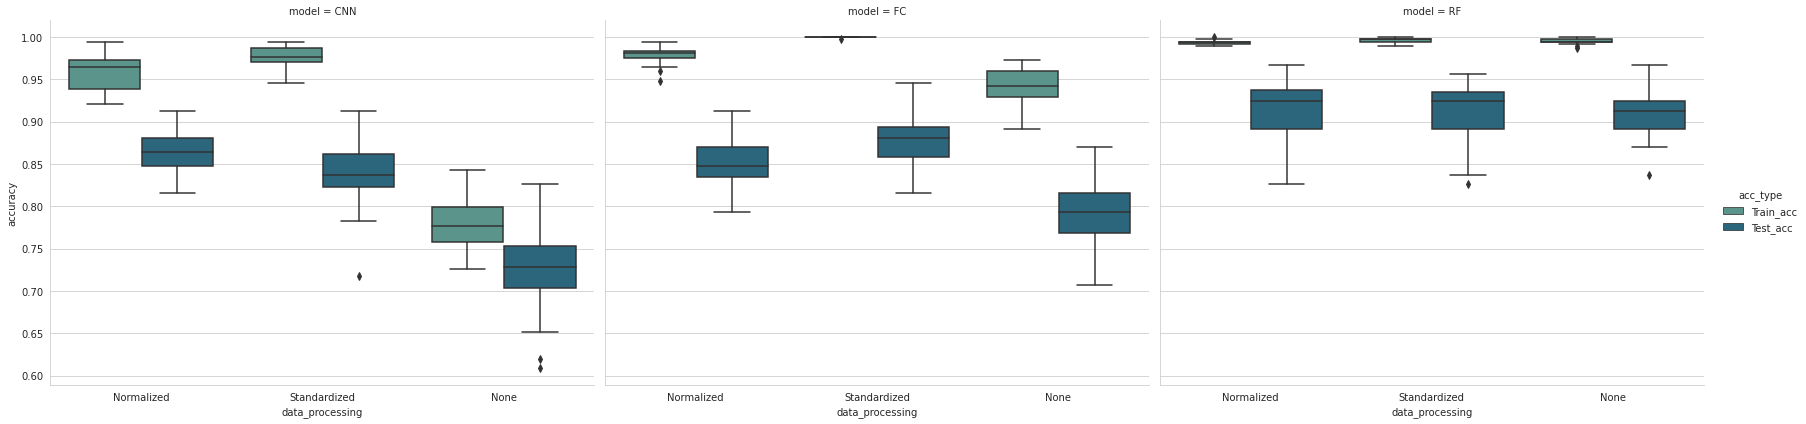

In [15]:
import seaborn as sns 
acc_prev =  pd.read_csv('result/acc_cnn_fc_all_zero').reset_index(drop=True)
acc_prev_rf =  pd.read_csv('result/acc_rf_all_zero').reset_index(drop=True)
acc_all = pd.concat([acc_prev ,  acc_prev_rf]).reset_index(drop=True)
sns.set_style('whitegrid')
sns.catplot(data = acc_all , y='accuracy' , x = 'data_processing' ,
            hue= 'acc_type'  , kind='box' ,  col ='model' , 
            palette = 'crest' , height=6 , aspect=8/6
            )
plt.savefig('result/model_var_rf.jpg')
plt.show()

In [16]:
data_og.describe()

,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,4.600000e+02,4.600000e+02,4.600000e+02,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.680500,-13.665727,-10.585485,-13.672153,-13.524028,-13.598865,-9.545423,-2.479007,-10.270777,-11.095915,...,3.976932e-14,3.684994e-14,4.187235e-14,1.109605,0.566298,0.565308,16.913367,20.985130,14.195144,0.158613
std,109.946267,3.758502,6.281784,3.562725,2.445021,1.872480,7.192002,5.508112,6.885564,5.952367,...,1.828352e-13,1.716889e-13,1.908868e-13,8.512305,2.798337,4.297048,110.659935,138.121021,94.621092,0.603954
min,2.110000,-16.403623,-16.286762,-16.438660,-16.050805,-16.001523,-17.513428,-16.808549,-17.283162,-16.795609,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.120000,-15.157782,-14.772950,-15.097236,-14.486419,-14.402365,-15.235153,0.000000,-15.289121,-14.680062,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23.470000,-14.736025,-13.558464,-14.643783,-13.813854,-13.795609,-14.031779,0.000000,-14.179348,-13.784101,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49.260000,-13.884391,0.000000,-13.880179,-13.312095,-13.246092,0.000000,0.000000,0.000000,-12.544880,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,376.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.674000e-12,1.627000e-12,1.726000e-12,100.000000,35.720000,81.320000,1472.000000,1712.000000,1380.000000,9.074000


In [105]:
with open("plot.html", "w") as f:
    f.write(tfdf.model_plotter.plot_model(
        model ,
        tree_idx = 250 ,
        max_depth = 20
        ))

## Comparison across Imputation

In [19]:
data_corr = pd.read_csv('processed_data/train_norm_corr' , index_col=0).reset_index(drop=True)
data_zero = pd.read_csv('processed_data/train_norm_zero' , index_col=0).reset_index(drop=True)
data_mean = pd.read_csv('processed_data/train_norm_mean' , index_col=0).reset_index(drop=True)
data_median = pd.read_csv('processed_data/train_norm_median' , index_col=0).reset_index(drop=True)
data_corr.head(2)

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
0,NS,J1748-2021#2,NS0056,6.25,0.335171,0.168648,0.376587,0.254273,0.287741,0.376253,...,0.039243,0.043996,0.036741,0.331771,0.049034,0.434538,0.905741,0.850661,0.986117,0.694600
1,NS,EXO 1745-248,NS0020,23.47,0.354061,0.569897,0.493711,0.459409,0.481761,0.403466,...,0.040868,0.045665,0.038351,0.453253,0.062636,0.616169,1.001875,0.941022,1.090491,0.705692


In [ ]:
acc_zero = mc_validation(gen_model_rf , data_corr , obs_split ,model_name = 'RF' , d_type='Normalized' , impute_method='Zero')
acc_mean = mc_validation(gen_model_rf , data_zero , obs_split, model_name = 'RF' , d_type = 'Normalized' ,  impute_method='mean')
acc_median = mc_validation(gen_model_rf , data_mean  , obs_split ,  model_name = 'RF' , d_type = 'Normalized' ,  impute_method='median')
acc_corr = mc_validation(gen_model_rf , data_median  , obs_split ,  model_name = 'RF' , d_type = 'Normalized' ,  impute_method='correlation')

In [22]:
acc_data =  pd.concat([acc_zero , acc_mean , acc_median , acc_corr]).reset_index(drop=True)
acc_data

,model,impute_method,data_processing,acc_type,accuracy
0,RF,Zero,Normalized,Train_acc,0.991848
1,RF,Zero,Normalized,Train_acc,0.991848
2,RF,Zero,Normalized,Train_acc,0.991848
3,RF,Zero,Normalized,Train_acc,0.991848
4,RF,Zero,Normalized,Train_acc,0.994565
...,...,...,...,...,...
251,RF,correlation,Normalized,Test_acc,0.934783
252,RF,correlation,Normalized,Test_acc,0.923913
253,RF,correlation,Normalized,Test_acc,0.913043
254,RF,correlation,Normalized,Test_acc,0.923913


In [23]:
acc_data.to_csv('result/acc_rf_norm_all')

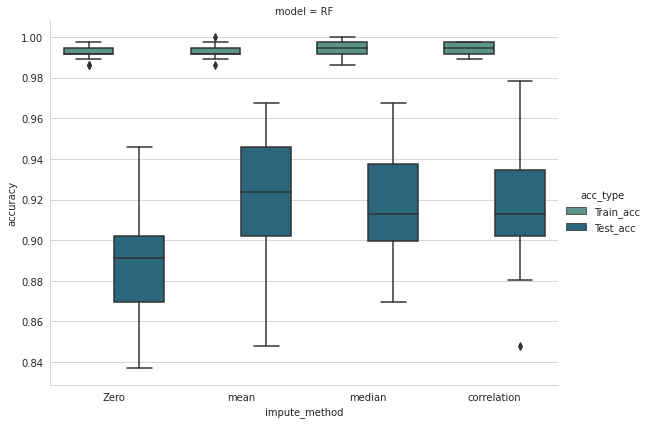

In [26]:
sns.catplot(data = acc_data , y='accuracy' , x = 'impute_method' ,
            hue= 'acc_type'  , kind='box' ,  col ='model' , 
            palette = 'crest' , height=6 , aspect=8/6
            )
plt.savefig('result/model_var_rf.jpg')
plt.show()